## Grid Search

In this notebook, we tune the BM25 parameters `k1` and `b` using grid search. We evaluate all parameter combinations defined in the `param_grid` below directly on the full sample of 1500 documents and queries.

In [8]:
import pandas as pd
import string

In [ ]:
# load the documents
stratified_sample = pd.read_csv('data/stratified_sample_with_queries.csv')

corpus = pd.read_csv('data/corpus_without_outliers.csv.zip')

In [ ]:
# what we found to be the original preprocessing function.
# removing punctuation, lowercasing all text and using NLTK's word_tokenize().

import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess_columns(column):
    # Lowercase and remove punctuation using vectorized string methods
    clean_series = column.str.lower().str.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize using nltk's word_tokenize
    return clean_series.apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# evaluation

from rank_eval import Qrels, Run, evaluate

def evaluate_bm25(dataframe: pd.DataFrame, true_column='celex_id', retrieved_column='retrieved_celex_ids', metrics=["recall@1", "mrr", "ndcg@5"]):

    # initialize Qrels: the ground truth
    qrels = Qrels()
    qrels.add_multi(
        q_ids=dataframe[true_column].tolist(),
        doc_ids=[[row] for row in dataframe[true_column].tolist()],
        scores=[[1] for _ in range(len(dataframe))]  
    )

     # initialize Run: the retrieved results
    run = Run()
    run.add_multi(
        q_ids=dataframe[true_column].tolist(),
        doc_ids=dataframe[retrieved_column].tolist(),
        scores=[
            [len(retrieved) - i for i, _ in enumerate(retrieved)]
            for retrieved in dataframe[retrieved_column]
        ]
    )
    results = evaluate(qrels, run, metrics)

    return results # dictionary

In [ ]:
# heatmap for visualizing the grid search

import matplotlib.pyplot as plt
import seaborn as sns

def plot_bm25_heatmap(results_grid, output_path="bm25_gridsearch_heatmap.pdf"):
    df_results = pd.DataFrame(results_grid)
    pivot_table = df_results.pivot_table(values='score', index='k1', columns='b')

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, cmap='viridis')
    plt.title('BM25 Parameter Tuning: Recall@1')
    plt.xlabel('b')
    plt.ylabel('k1')
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()


In [ ]:
# the grid search

import bm25s
from sklearn.model_selection import ParameterGrid

def find_best_parameters(text_column, query_column, celex_ids):

    best_score = -1 # initialize scores and parameters
    best_params = None
    results_grid = [] # store results for heatmap

    corpus_tokens = preprocess_columns(text_column)
    query_tokens = preprocess_columns(query_column)

    param_grid = {
    "k1": [0.9, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.1],
    "b": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

    for params in ParameterGrid(param_grid):
        celex_ids = list(celex_ids)

        retriever = bm25s.BM25(k1=params["k1"], b=params["b"])
        retriever.index(corpus_tokens)

        results = retriever.retrieve(query_tokens, corpus=celex_ids, k=50, return_as="documents") # returns a numpy array
    
        temp_df = stratified_sample.copy()
        temp_df['retrieved_celex_ids'] = results.tolist()
        comparison_df = temp_df[['celex_id', 'retrieved_celex_ids']]

        results = evaluate_bm25(comparison_df)
        score = results.get('recall@1')

        results_grid.append({
            "k1": params["k1"],
            "b": params["b"],
            "score": score
        })

        print(f"Parameters: {params}, Score: {score}")

        if score > best_score:
            best_score = score
            best_params = params
    
    # call the separate heatmap function
    plot_bm25_heatmap(results_grid)
        
    print(f"Best Parameters: {best_params}, Best Score: {best_score}")
    return best_params, best_score

BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 0.9}, Score: 0.4613333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.1}, Score: 0.462


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.2}, Score: 0.466


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.3}, Score: 0.4713333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.4}, Score: 0.4706666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.5}, Score: 0.474


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.6}, Score: 0.4713333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.7}, Score: 0.4693333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.8}, Score: 0.4646666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.9}, Score: 0.462


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 2.1}, Score: 0.45866666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 0.9}, Score: 0.47933333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.1}, Score: 0.48933333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.2}, Score: 0.48933333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.3}, Score: 0.49066666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.4}, Score: 0.49133333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.5}, Score: 0.49


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.6}, Score: 0.49066666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.7}, Score: 0.486


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.8}, Score: 0.486


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.9}, Score: 0.48333333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 2.1}, Score: 0.4766666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 0.9}, Score: 0.49466666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.1}, Score: 0.5


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.2}, Score: 0.506


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.3}, Score: 0.5033333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.4}, Score: 0.5033333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.5}, Score: 0.502


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.6}, Score: 0.5006666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.7}, Score: 0.5013333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.8}, Score: 0.498


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.9}, Score: 0.49733333333333335


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 2.1}, Score: 0.49933333333333335


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 0.9}, Score: 0.5073333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.1}, Score: 0.5073333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.2}, Score: 0.5073333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.3}, Score: 0.512


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.4}, Score: 0.512


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.5}, Score: 0.5106666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.6}, Score: 0.5133333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.7}, Score: 0.51


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.8}, Score: 0.5133333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.9}, Score: 0.5126666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 2.1}, Score: 0.5126666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 0.9}, Score: 0.5153333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.1}, Score: 0.516


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.2}, Score: 0.5186666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.3}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.4}, Score: 0.522


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.5}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.6}, Score: 0.522


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.7}, Score: 0.5253333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.8}, Score: 0.522


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.9}, Score: 0.518


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 2.1}, Score: 0.5166666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 0.9}, Score: 0.5153333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.1}, Score: 0.522


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.2}, Score: 0.5273333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.3}, Score: 0.528


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.4}, Score: 0.5266666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.5}, Score: 0.524


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.6}, Score: 0.524


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.7}, Score: 0.524


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.8}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.9}, Score: 0.518


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 2.1}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 0.9}, Score: 0.5246666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.1}, Score: 0.5286666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.2}, Score: 0.5326666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.3}, Score: 0.5293333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.4}, Score: 0.5286666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.5}, Score: 0.5266666666666666


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.6}, Score: 0.5293333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.7}, Score: 0.5253333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.8}, Score: 0.524


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.9}, Score: 0.524


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 2.1}, Score: 0.52


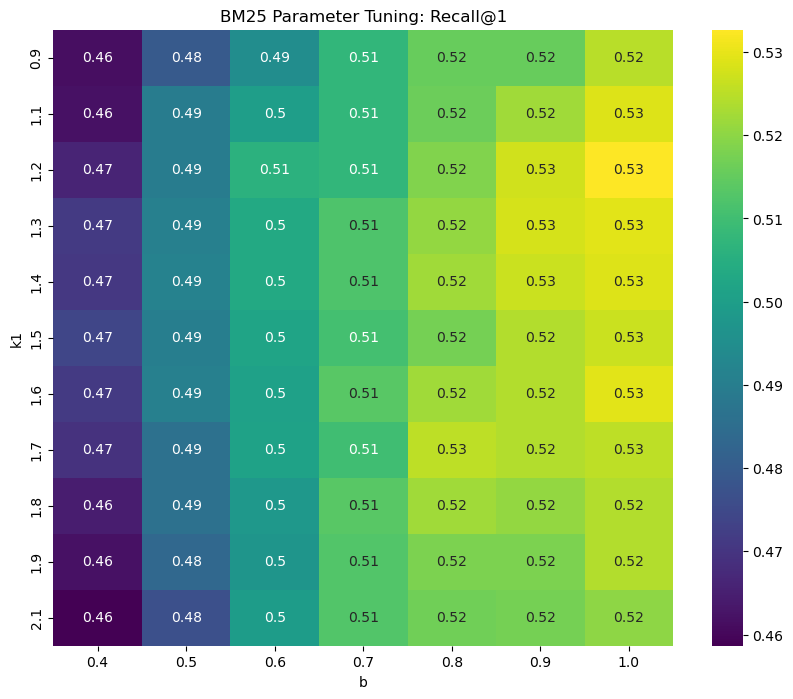

Best Parameters: {'b': 1.0, 'k1': 1.2}, Best Score: 0.5326666666666666


In [ ]:
# first we look for the best_params for English

best_params, best_score = find_best_parameters(corpus['text_en'], stratified_sample['query_en'], corpus['celex_id'])

BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 0.9}, Score: 0.47333333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.1}, Score: 0.4746666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.2}, Score: 0.47533333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.3}, Score: 0.4746666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.4}, Score: 0.47333333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.5}, Score: 0.4706666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.6}, Score: 0.47


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.7}, Score: 0.472


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.8}, Score: 0.4713333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 1.9}, Score: 0.4713333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.4, 'k1': 2.1}, Score: 0.464


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 0.9}, Score: 0.484


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.1}, Score: 0.4886666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.2}, Score: 0.488


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.3}, Score: 0.48933333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.4}, Score: 0.4886666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.5}, Score: 0.4886666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.6}, Score: 0.484


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.7}, Score: 0.484


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.8}, Score: 0.4826666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 1.9}, Score: 0.48


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.5, 'k1': 2.1}, Score: 0.4826666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 0.9}, Score: 0.5


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.1}, Score: 0.49466666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.2}, Score: 0.5


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.3}, Score: 0.49733333333333335


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.4}, Score: 0.49666666666666665


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.5}, Score: 0.49866666666666665


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.6}, Score: 0.49466666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.7}, Score: 0.49866666666666665


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.8}, Score: 0.496


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 1.9}, Score: 0.49066666666666664


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.6, 'k1': 2.1}, Score: 0.49133333333333334


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 0.9}, Score: 0.5033333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.1}, Score: 0.5033333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.2}, Score: 0.508


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.3}, Score: 0.512


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.4}, Score: 0.51


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.5}, Score: 0.51


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.6}, Score: 0.5086666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.7}, Score: 0.508


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.8}, Score: 0.5086666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 1.9}, Score: 0.5073333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.7, 'k1': 2.1}, Score: 0.5013333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 0.9}, Score: 0.5133333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.1}, Score: 0.514


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.2}, Score: 0.514


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.3}, Score: 0.5146666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.4}, Score: 0.5153333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.5}, Score: 0.5186666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.6}, Score: 0.5166666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.7}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.8}, Score: 0.5146666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 1.9}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.8, 'k1': 2.1}, Score: 0.512


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 0.9}, Score: 0.512


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.1}, Score: 0.516


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.2}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.3}, Score: 0.5186666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.4}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.5}, Score: 0.5193333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.6}, Score: 0.5166666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.7}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.8}, Score: 0.516


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 1.9}, Score: 0.516


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 0.9, 'k1': 2.1}, Score: 0.5106666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 0.9}, Score: 0.5146666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.1}, Score: 0.5166666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.2}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.3}, Score: 0.5206666666666667


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.4}, Score: 0.5193333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.5}, Score: 0.518


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.6}, Score: 0.5173333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.7}, Score: 0.5193333333333333


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.8}, Score: 0.52


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 1.9}, Score: 0.518


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

Parameters: {'b': 1.0, 'k1': 2.1}, Score: 0.5153333333333333


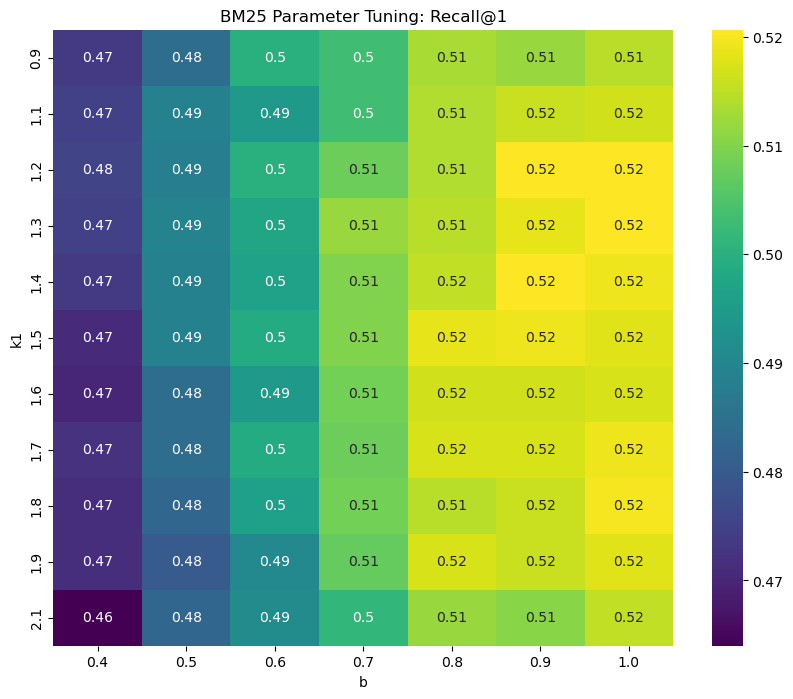

Best Parameters: {'b': 0.9, 'k1': 1.2}, Best Score: 0.5206666666666667


In [ ]:
# then we do the same for for Dutch
best_params, best_score = find_best_parameters(corpus['text_nl'], stratified_sample['query_nl'], corpus['celex_id'])

In [ ]:
# the found best parameters for each language can now be used for the rest of the experiment